# Notebook to replicate the analysis proposed in the Section Data of the paper

In [203]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
import sys

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")

import hnx
from hnx import Hypergraph
from hnx.readwrite import load_hypergraph
from hnx.communities.hypergraph_mt.model import HypergraphMT
from hnx.viz import *

### Input data

In [221]:
H = load_hypergraph("../test_data/hs/hs_one_class.pickle", "pickle")
print(H)

Hypergraph with 136 nodes and 765 edges.
Distribution of hyperedge sizes: {2: 576, 3: 173, 4: 16}


### A) Higher-order degree distributions for different orders

<Axes: xlabel='Degree', ylabel='Frequency'>

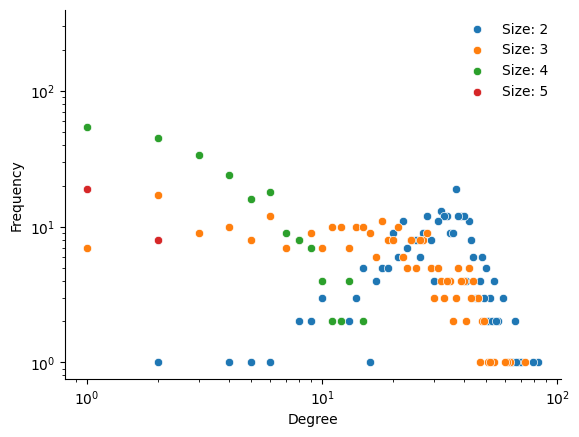

In [130]:
from hnx.viz.plot import plot_degree_distributions

plot_degree_distributions(H, max_size=5)

### B) Motifs 
(exact approach only)

In [131]:
from hnx.motifs.motifs import compute_motifs

motifs = compute_motifs(H, order=3)
print(motifs)

[(((1, 2), (1, 2, 3)), 58), (((1, 2), (1, 2, 3), (1, 3)), 231), (((1, 2), (1, 2, 3), (1, 3), (2, 3)), 1802), (((1, 2), (1, 3)), 115709), (((1, 2), (1, 3), (2, 3)), 28029), (((1, 2, 3),), 0)]


### C) Communities 
(one approach only) and comparison with metadata

In [79]:
# Model training
model = HypergraphMT(verbose=False)
u, w, maxL = model.fit(H, K=5, seed=10, normalizeU=False, out_inference=False, )

KeyboardInterrupt: 

In [ ]:
# TODO: Marti - plot overlapping communities vs metadata (probably on the clique expansion) 
# - add draw_communities in viz

### D) Statistics of the filtered systems after applying SVH
(one statistic of Fede’s choice, for instance fraction of preserved higher-order interactions for each order after
applying the SVH filter. It is better if the dataset has at least 4 different orders, but again it is a trade-off)

In [ ]:
# TODO: Federico M.

### E) Ability of the sampling method to reproduce one measure 
(one centrality measure distribution not covered so far)

In [ ]:
# TODO: Nick

### F) Temporal higher-order properties
one plot from the work of Luca (let us produce an alternative figure with respect to the arXiv. It should be a figure less cool, we keep the cool figure for the original work (one centrality measure distribution not covered so far)

In [ ]:
# TODO: Luca

### G) Statistics of a higher-order spreading process run on top of it 
(e.g. number of infected individuals as a function of time for some parameters lambda pairwise and triangles (please write the value of the parameters in the main text or in the caption). I suggest we choose a social system, because otherwise this does not make sense

In [ ]:
# TODO

### H) 2 or 3 of different visualizations 
chosen by Francesco and Martina.

In [311]:
H = load_hypergraph("../test_data/hs/hs_one_class.pickle", "pickle")
print(H)

Hypergraph with 40 nodes and 955 edges.
Distribution of hyperedge sizes: {2: 570, 3: 345, 4: 38, 5: 2}


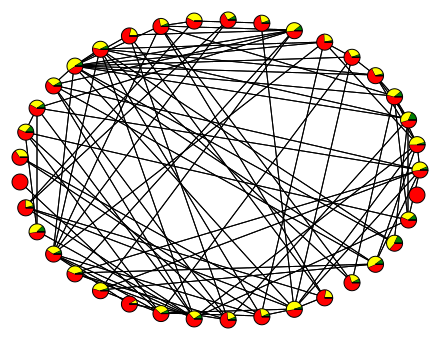

In [183]:
from hnx.viz.draw_pie import draw_pie
from IPython.display import SVG

SVG(draw_pie(H, num_edges=100))

In [312]:
from hnx.filters import get_svh

hs_svh = get_svh(H, approximate_pvalue=True, mp=True)

In [338]:
e4 = hs_svh[4]
e4 = e4[e4['fdr']]
lim = e4['pvalue']
lim = list(lim)
lim = list(sorted(lim))
print(lim)
lim = lim[3]

[1.7476793314781848e-13, 6.087861861602061e-11, 7.104492383003577e-10, 7.222002313850705e-09, 3.6406034077450105e-07, 4.859228967489003e-07, 8.05946252278273e-07, 9.598837894193928e-07]


In [339]:
edges = []
lim = float(lim)

for size in hs_svh:
    for i in range(len(hs_svh[size])):
        a = float(hs_svh[size]['pvalue'][i])
        b = bool(hs_svh[size]['fdr'][i])
        if a <= lim and b:
            edges.append(hs_svh[size]['edge'][i])

print(len(edges))

H2 = Hypergraph(edges)
lcc = H2.largest_component()
H2 = H2.subhypergraph(lcc)


77


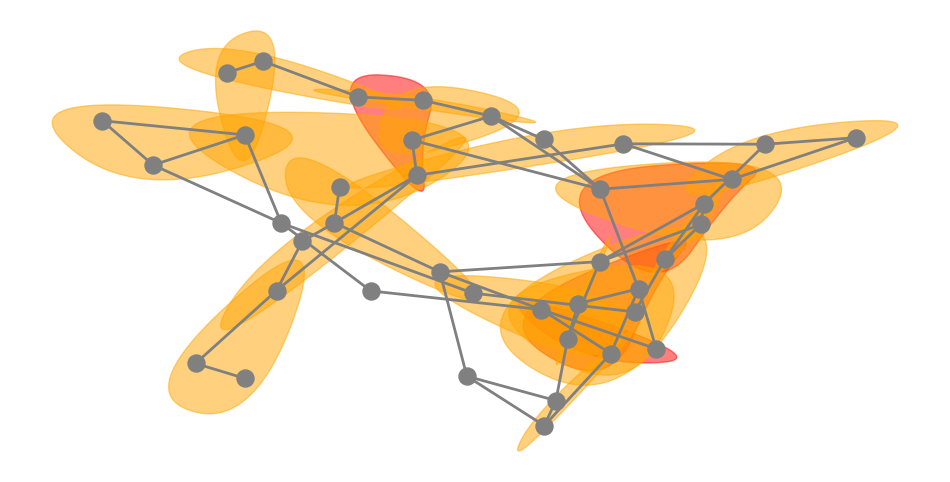

In [340]:
figsize = (12,6)
plt.figure(figsize = figsize)
draw_HG(H2, link_color='grey', node_color='gray', hyperlink_color_by_order = {2:'orange', 3:'r'})

In [ ]:
# TODO: Francesco and Marti

# MC: it would be nice if one plot is the representation of the hypernetwork with the hypergraph visualization 

In [ ]:
# So far they do not look nice

KeyboardInterrupt: 

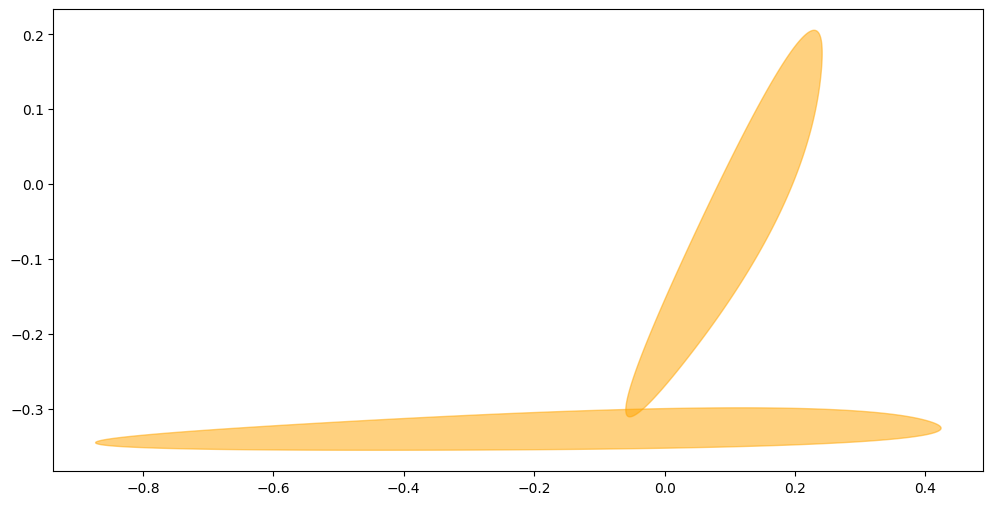

In [194]:
figsize = (12,6)
plt.figure(figsize = figsize)
draw_HG(H, link_color='grey', node_color='gray', hyperlink_color_by_order = {2:'orange', 3:'r'})

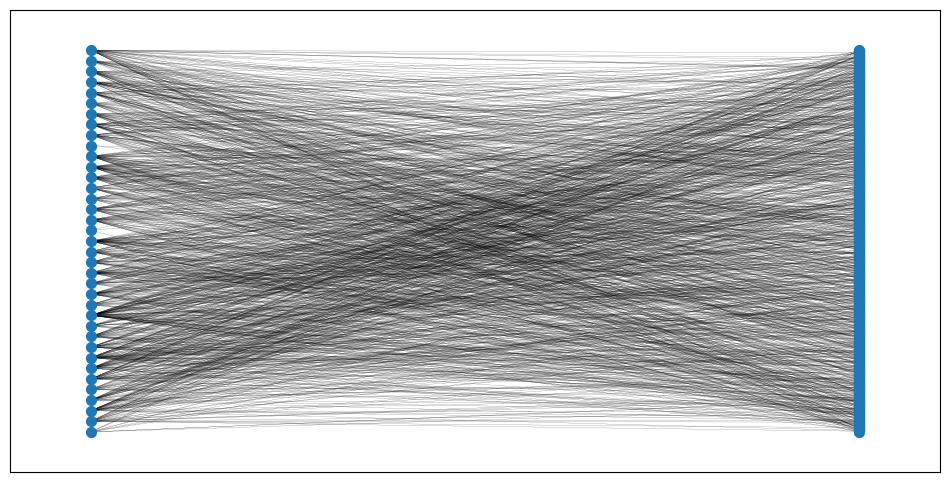

In [202]:
figsize = (12,6)
plt.figure(figsize = figsize)
draw_bipartite(H, node_size=50, with_labels=False, width=0.1)
plt.show()

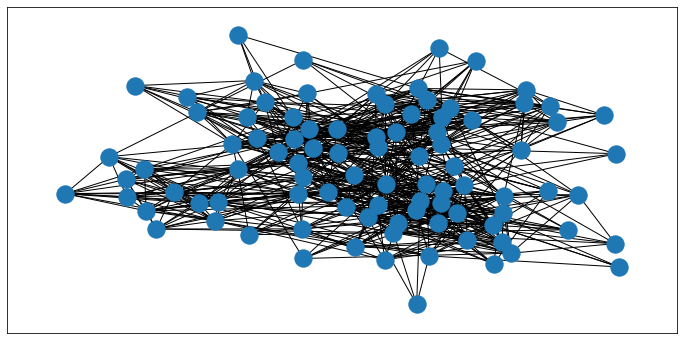

In [ ]:
figsize = (12,6)
plt.figure(figsize = figsize)
draw_clique(H, with_labels=False)
plt.show()